# Fine-tune SAM on satellite images

## Load dataset

Here we load a small dataset of 130 (image, ground truth mask) pairs.

To load your own images and masks, refer to the bottom of my [SAM inference notebook](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/SAM/Run_inference_with_MedSAM_using_HuggingFace_Transformers.ipynb).

See also [this guide](https://huggingface.co/docs/datasets/image_dataset). 

In [1]:
from datasets import load_dataset

dataset = load_dataset("keremberke/satellite-building-segmentation", "mini")

Found cached dataset satellite-building-segmentation (/h/vkhazaie/.cache/huggingface/datasets/keremberke___satellite-building-segmentation/mini/1.0.0/2d4f5155d8a688bdff0915214924fbee078bcc85eb80f4d3c5884b8e319ec0ea)


  0%|          | 0/3 [00:00<?, ?it/s]

In [2]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 3
    })
    validation: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 3
    })
    test: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 3
    })
})

We can visualize an example:

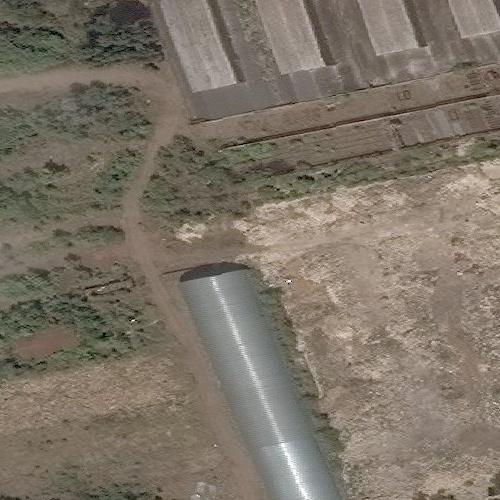

In [3]:
example = dataset['train'][0]
image = example["image"]
image

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from pycocotools import mask as coco_mask

def get_segmentation_mask(segmentation_label):
    # Convert COCO segmentation label to binary mask
    binary_mask= np.zeros((500, 500, 1))
    for seg_lbl in segmentation_label['segmentation']:
        rle = coco_mask.frPyObjects(seg_lbl, 500, 500)
        binary_mask += coco_mask.decode(rle)
    
    return binary_mask

In [5]:
mask = get_segmentation_mask(dataset["train"]["objects"][0])

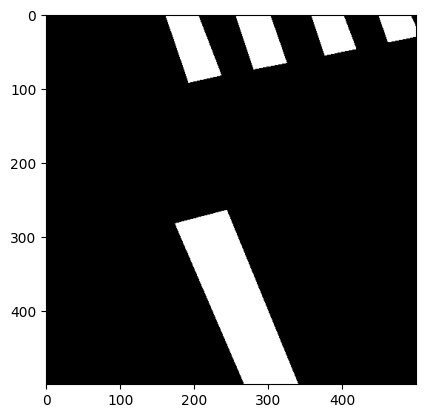

In [6]:
plt.imshow(mask, cmap="gray")

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

def show_bounding_boxes(image, bounding_boxes):
    # Create a figure and axes
    fig, ax = plt.subplots(1)

    # Display the image
    ax.imshow(image)

    # Plot bounding boxes
    for bbox in bounding_boxes:
        x, y, width, height = bbox
        rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    # Configure plot settings
    ax.axis('off')
    plt.show()

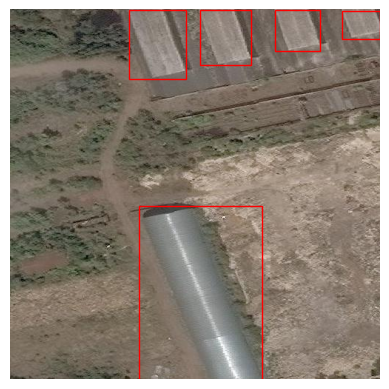

In [8]:
show_bounding_boxes(dataset["train"]["image"][0], dataset["train"]["objects"][0]['bbox'])

## Create PyTorch dataset

Below we define a regular PyTorch dataset, which gives us examples of the data prepared in the format for the model. Each example consists of:

* pixel values (which is the image prepared for the model)
* a prompt in the form of a bounding box
* a ground truth segmentation mask.

The function below defines how to get a bounding box prompt based on the ground truth segmentation. This was taken from [here](https://github.com/bowang-lab/MedSAM/blob/66cf4799a9ab9a8e08428a5087e73fc21b2b61cd/train.py#L29).

In [17]:
from torch.utils.data import Dataset


class SAMDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)


    def convert_bboxes(self, bboxes):
        converted_bboxes = []
        for bbox in bboxes:
            x_min, y_min, width, height = bbox
            x_max = x_min + width
            y_max = y_min + height
            converted_bboxes.append([x_min, y_min, x_max, y_max])
        return np.array(converted_bboxes)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item["image"]

        # get bounding box prompt
        box_prompt = np.array(item['objects']['bbox'])
        box_prompt = self.convert_bboxes(box_prompt)

        # prepare image and prompt for the model
        inputs = self.processor(image, input_boxes=[[[box_prompt]]], return_tensors="pt")

        # remove batch dimension which the processor adds by default
        inputs = {k:v.squeeze(0) for k,v in inputs.items()}

        # add ground truth segmentation
        inputs["ground_truth_mask"] = get_segmentation_mask(item["objects"]).reshape((1, 500, 500))

        return inputs

In [18]:
from transformers import SamProcessor

processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [19]:
train_dataset = SAMDataset(dataset=dataset['train'], processor=processor)

In [20]:
example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([5, 4])
ground_truth_mask (1, 500, 500)


## Create PyTorch DataLoader

Next we define a PyTorch Dataloader, which allows us to get batches from the dataset.



In [21]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)

In [22]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([1, 3, 1024, 1024])
original_sizes torch.Size([1, 2])
reshaped_input_sizes torch.Size([1, 2])
input_boxes torch.Size([1, 5, 4])
ground_truth_mask torch.Size([1, 1, 500, 500])


## Load the model

In [23]:
from transformers import SamModel 

model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
    if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
        param.requires_grad_(False)

In [16]:
# from transformers import pipeline
# generator = pipeline("mask-generation", model="facebook/sam-vit-base", device=0)

In [17]:
# outputs = generator(dataset["train"]["image"][0], points_per_batch=64)

## Train the model

In [99]:
model_type = 'vit_h'
checkpoint = 'sam_vit_h_4b8939.pth'
device = 'cuda:0'

from segment_anything import SamPredictor, sam_model_registry
sam_model = sam_model_registry[model_type](checkpoint=checkpoint)
sam_model.to(device)
sam_model.eval()

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

In [100]:
from torch.nn.functional import threshold, normalize

In [101]:
import torch

from segment_anything.utils.transforms import ResizeLongestSide

In [144]:
def convert_bboxes(bboxes):
    converted_bboxes = []
    for bbox in bboxes:
        x_min, y_min, width, height = bbox
        x_max = x_min + width
        y_max = y_min + height
        converted_bboxes.append([x_min, y_min, x_max, y_max])
    return np.array(converted_bboxes)

In [145]:
image = np.array(dataset["test"]["image"][idx])
prompt_box = np.array(dataset["test"]["objects"][idx]['bbox'])
prompt_box = convert_bboxes(prompt_box)

In [146]:
# No grad here as we don't want to optimise the encoders
with torch.no_grad():
    transform = ResizeLongestSide(sam_model.image_encoder.img_size)
    input_image = transform.apply_image(image)
    input_image_torch = torch.as_tensor(input_image, device=device)
    transformed_image = input_image_torch.permute(2, 0, 1).contiguous()[None, :, :, :]

    input_image = sam_model.preprocess(transformed_image)
    original_image_size = image.shape[:2]
    input_size = tuple(transformed_image.shape[-2:])
    
    image_embedding = sam_model.image_encoder(input_image)

    box = transform.apply_boxes(prompt_box, original_image_size)
    box_torch = torch.as_tensor(box, dtype=torch.float, device=device)

    sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
      points=None,
      boxes=box_torch,
      masks=None,
    )
    low_res_masks, iou_predictions = sam_model.mask_decoder(
    image_embeddings=image_embedding,
    image_pe=sam_model.prompt_encoder.get_dense_pe(),
    sparse_prompt_embeddings=sparse_embeddings,
    dense_prompt_embeddings=dense_embeddings,
    multimask_output=False,
    )

    upscaled_masks = sam_model.postprocess_masks(low_res_masks, input_size, original_image_size).to(device)
#     upscaled_masks = (upscaled_masks - upscaled_masks.min()) / (upscaled_masks.max() - upscaled_masks.min())
#     binary_mask = upscaled_masks > 0.0
    binary_mask = normalize(threshold(upscaled_masks, 0.0, 0))

In [147]:
binary_mask.min()

tensor(0., device='cuda:0')

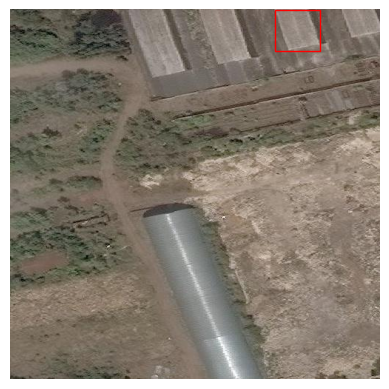

In [148]:
show_bounding_boxes(dataset["test"]["image"][idx], [dataset["test"]["objects"][idx]['bbox'][0]])

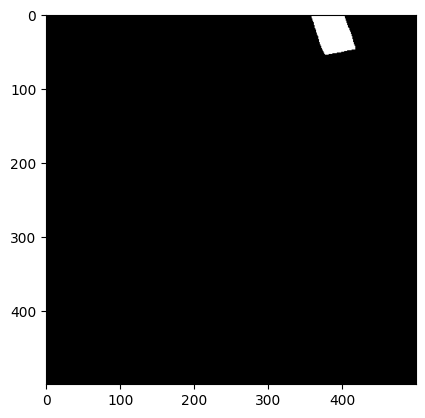

In [156]:
plt.imshow(binary_mask[0].detach().cpu().numpy().squeeze(), cmap='binary_r')

In [24]:
# import monai
from torch.optim import Adam
import torch

# Note: Hyperparameter tuning could improve performance here
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)

# seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')
seg_loss = loss = torch.nn.MSELoss()

In [36]:
from tqdm import tqdm
from statistics import mean
import torch
import torch.nn.functional as F
from torch.nn.functional import threshold, normalize


num_epochs = 50

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
      # forward pass
      outputs = model(pixel_values=batch['pixel_values'].to(device),
                      input_boxes=batch['input_boxes'].to(device),
                      multimask_output=False)
      # compute loss
      predicted_masks = outputs.pred_masks.sum(axis=1)
        masks = threshold(masks, 0.0, 0)
      ground_truth_masks = batch['ground_truth_mask'].float().to(device)
      masks = F.interpolate(predicted_masks, (500, 500), mode="bicubic", align_corners=False)
#       masks = (masks - masks.min()) / (masks.max() - masks.min())
#       binary_masks = torch.where(masks >= 0.5, torch.tensor(1.0), torch.tensor(0.0))
      masks = threshold(masks, 0.0, 0)

      loss = seg_loss(masks, ground_truth_masks)

      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()

      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

IndentationError: unexpected indent (3485429778.py, line 23)

In [33]:
masks.shape

torch.Size([1, 1, 500, 500])

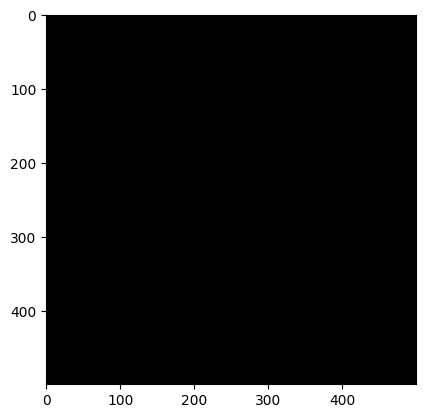

In [34]:
plt.imshow(masks.detach().cpu().numpy().squeeze(), cmap='binary_r')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


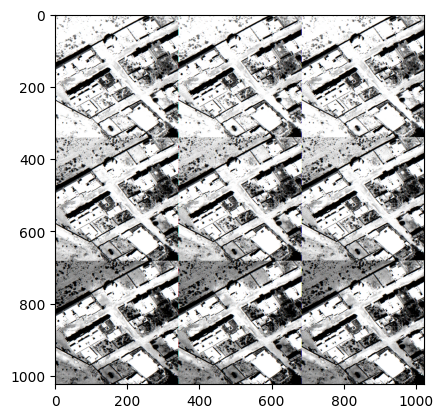

In [35]:
plt.imshow(batch['pixel_values'].detach().cpu().numpy().reshape(1024,1024,3), cmap='binary_r')

## Inference

Important note here: as we used the Dice loss with `sigmoid=True`, we need to make sure to appropriately apply a sigmoid activation function to the predicted masks. Hence we won't use the processor's `post_process_masks` method here.

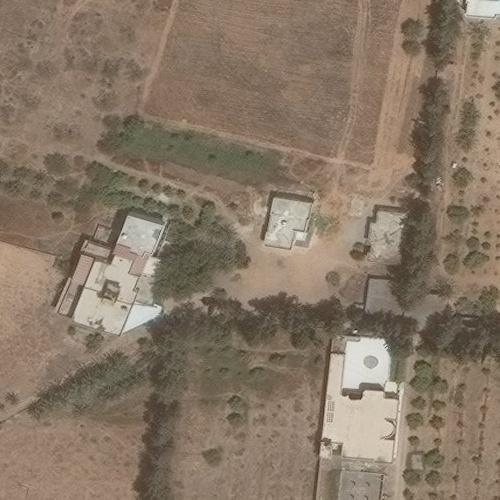

In [86]:
import numpy as np
from PIL import Image

# let's take a random training example
idx = 0

# load image
image = dataset['test'][idx]["image"]
image

In [89]:
# get box prompt based on ground truth segmentation map
ground_truth_mask = np.array(get_segmentation_mask(dataset['test'][idx]['objects']))
prompt = dataset['test'][idx]['objects']['bbox']

# prepare image + box prompt for the model
inputs = processor(image, input_boxes=[[prompt]], return_tensors="pt").to(device)
for k,v in inputs.items():
  print(k,v.shape)

AttributeError: to

In [90]:
model.eval()

# forward pass
with torch.no_grad():
  outputs = model(**inputs, multimask_output=False)

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [32]:
# apply sigmoid
sam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
sam_seg_prob = sam_seg_prob.cpu().numpy().squeeze()
sam_seg = (sam_seg_prob > 0.5).astype(np.uint8)

(-0.5, 499.5, 499.5, -0.5)

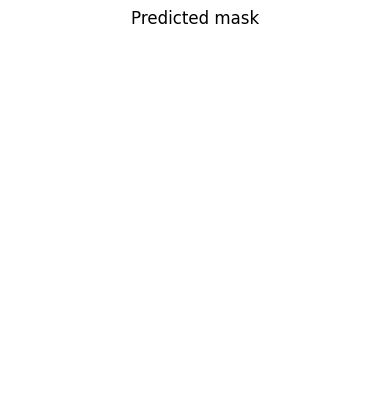

In [33]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

fig, axes = plt.subplots()

axes.imshow(np.array(image))
show_mask(sam_seg, axes)
axes.title.set_text(f"Predicted mask")
axes.axis("off")

Compare this to the ground truth segmentation:

(-0.5, 255.5, 255.5, -0.5)

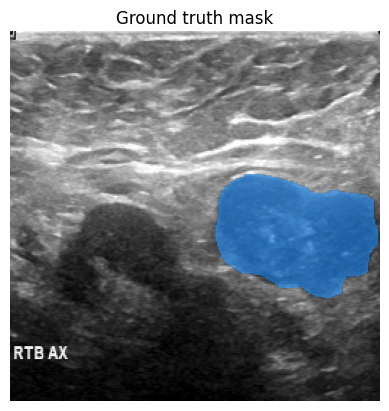

In [ ]:
fig, axes = plt.subplots()

axes.imshow(np.array(image))
show_mask(ground_truth_mask, axes)
axes.title.set_text(f"Ground truth mask")
axes.axis("off")

## Legacy

The code below was used during the creation of this notebook, but was eventually not used anymore.

In [ ]:
# import torch.nn.functional as F
# from typing import Tuple
# from torch.nn import MSELoss

# loss_fn = MSELoss()

# def postprocess_masks(masks):
#     """
#     Remove padding and upscale masks to the original image size.

#     Args:
#       masks (torch.Tensor):
#         Batched masks from the mask_decoder, in BxCxHxW format.
#       input_size (tuple(int, int)):
#         The size of the image input to the model, in (H, W) format. Used to remove padding.
#       original_size (tuple(int, int)):
#         The original size of the image before resizing for input to the model, in (H, W) format.

#     Returns:
#       (torch.Tensor): Batched masks in BxCxHxW format, where (H, W)
#         is given by original_size.
#     """
#     masks = F.interpolate(
#         masks,
#         (500, 500),
#         mode="bilinear",
#         align_corners=False,
#     )
#     masks = masks[..., : 500 : 500]
#     masks = F.interpolate(masks, 500, mode="bilinear", align_corners=False)
#     return masks

In [ ]:
# # upscaled_masks = postprocess_masks(predicted_masks.sum(axis=1).squeeze(1)).to(device)
# masks = F.interpolate(
#     predicted_masks.squeeze(1).sum(axis=1),
#     (500, 500),
#     mode="bilinear",
#     align_corners=False)
# predicted_masks = normalize(threshold(masks, 0.0, 0)).squeeze(1)
# loss = loss_fn(predicted_masks, ground_truth_masks) 

ValueError: ignored

In [ ]:
# loss

tensor(0.3039, device='cuda:0', dtype=torch.float64,
       grad_fn=<MseLossBackward0>)

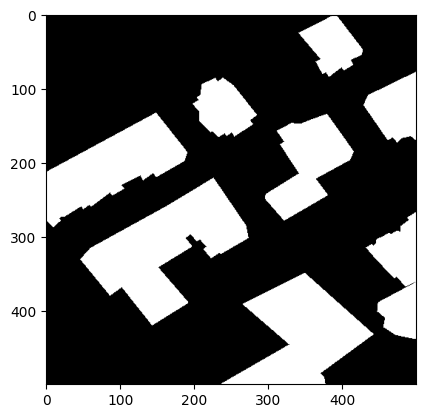

In [ ]:
# plt.imshow(ground_truth_masks.reshape((500, 500, 1)).detach().cpu().numpy(), cmap='gray')

In [ ]:
# ground_truth_masks.shape

torch.Size([1, 1, 500, 500])